In [1]:
import gzip

import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binomtest 
from statsmodels.stats import multitest

pd.set_option("display.max_columns", None)

Read thresholded dataframe with LOH positions

In [2]:
threshold = 10
folder = "LOH_pos_mmml_thresholded"
readfile = f"/home/junkhann/daten/{folder}/LOH_positions_threshold_{threshold}.tsv.gz"

In [3]:
df = pd.read_csv(readfile, sep="\t", compression="gzip")
len(df)

10126763

In [4]:
def get_number_ref_alleles(entry: str) -> int:
    return entry.split(",")[0]

In [5]:
def get_number_alt_alleles(entry: str) -> int:
    return entry.split(",")[1]

In [6]:
# tumor_genotype field is "ref,alt"
df["n_ref_alleles"] = df["tumor_genotype"].apply(get_number_ref_alleles)
df["n_alt_alleles"] = df["tumor_genotype"].apply(get_number_alt_alleles)

In [7]:
df.head()

,#CHROM,pos_x,REF,ALT,INFO,sample_control,sample_tumor,start,end,genotype,TCN,PID,normal_genotype,tumor_genotype,quality_score,reads_normal,reads_tumor,position_code,pos_y,position_count,n_ref_alleles,n_alt_alleles
0,3,116403329,G,A,BRF=0.35;FR=0.5;HP=8;HapScore=2;MGOF=70;MMLQ=3...,"1/0:-79.1,0,-43.8:43:99:48:28","1/0:-13.08,0,-37.58:70:99:14:4",116352805,116477856,1:0,1.0,4100314,"1,1","1,0",44.683650,48.0,14,3-116403329,3-116403329,15,1,0
1,3,116403329,G,A,BRF=0.37;FR=0.5;HP=8;HapScore=1;MGOF=244;MMLQ=...,"1/0:-31.72,0,-94.89:82:99:39:5","1/0:-43.64,0,-114.74:244:99:24:5",116135725,116608407,1:0,1.0,4101392,"1,1","1,0",99.000000,39.0,24,3-116403329,3-116403329,15,1,0
2,3,116403329,G,A,BRF=0.14;FR=0.5;HP=8;HapScore=2;MGOF=8;MMLQ=34...,"1/0:-36.86,0,-85.76:8:99:40:13","1/0:-55.87,0,-55.77:0:99:35:18",107000047,116590735,2:0,2.0,4104105,"1,1","0,2",2.880650,40.0,35,3-116403329,3-116403329,15,0,2
3,3,116403329,G,A,BRF=0.24;FR=0.5;HP=8;HapScore=6;MGOF=62;MMLQ=3...,"1/0:-40.66,0,-40.75:48:99:25:7","1/0:-54.41,0,-61:62:99:32:8",115787343,118705637,1:0,1.0,4108992,"1,1","1,0",99.000000,25.0,32,3-116403329,3-116403329,15,1,0
4,3,116403329,G,A,BRF=0.1;FR=0.5;HP=8;HapScore=3;MGOF=21;MMLQ=35...,"0/1:-23.59,0,-50.51:21:99:22:7","1/0:-28.8,0,-63:10:99:27:10",101685018,127432248,5:0,5.0,4111337,"1,1","5,0",66.184568,22.0,27,3-116403329,3-116403329,15,5,0


Perform binomial test for each position

In [9]:
def get_p_value(df_position: pd.DataFrame) -> tuple[float, float]:
    n = len(df_position)
    df_loss_ref = df_position[df_position["n_alt_alleles"] == "0"]
    k = len(df_loss_ref)
    result = binomtest(k=k, n=n, p=0.5, alternative="two-sided")
    return result.pvalue

In [10]:
p_values = df.groupby("position_code").apply(get_p_value)

Plot p-values

<Axes: title={'center': 'Distribution of p-values'}, xlabel='p-value', ylabel='Frequency'>

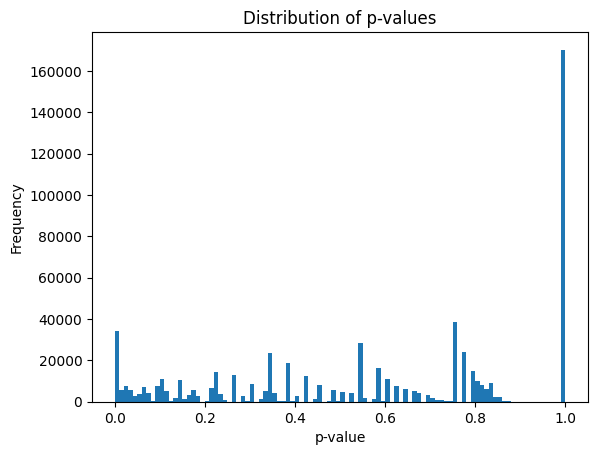

In [11]:
p_values.plot(kind="hist", bins=100, title="Distribution of p-values", xlabel="p-value")

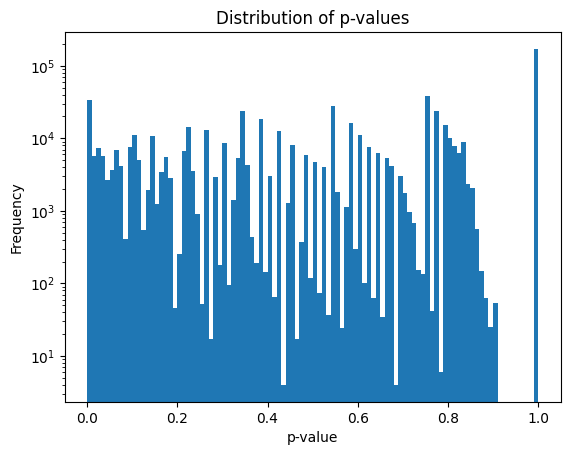

In [23]:
p_values.plot(kind="hist", bins=100, title="Distribution of p-values", xlabel="p-value")
plt.yscale("log")

Benjamini-Hochberg correction for multiple testing

In [13]:
rejected, adjusted_p_values, _, _ = multitest.multipletests(p_values, method='fdr_bh')

Text(0.5, 1.0, 'Distribution of p-values (adjusted by Benjamini-Hochberg correction)')

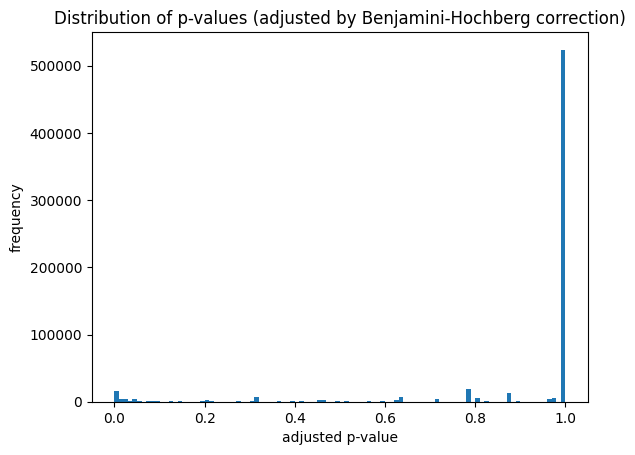

In [14]:
plt.hist(adjusted_p_values, bins=100)
plt.xlabel("adjusted p-value")
plt.ylabel("frequency")
plt.title("Distribution of p-values (adjusted by Benjamini-Hochberg correction)")

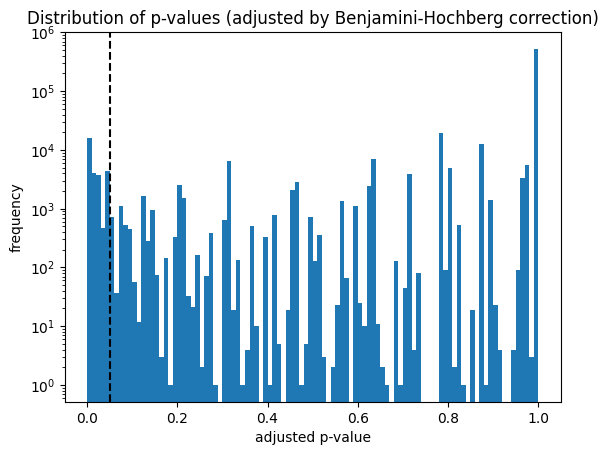

In [27]:
plt.hist(adjusted_p_values, bins=100)
plt.xlabel("adjusted p-value")
plt.ylabel("frequency")
plt.title("Distribution of p-values (adjusted by Benjamini-Hochberg correction)")
plt.yscale("log")
plt.axvline(x=0.05, linestyle="dashed", color="black")